# Transfer Learning With BERT (Self-Study)

- In this unit, we look at an example of transfer learning, where we build a sentiment classifier using the pre-trained BERT model.
- We use the `transformers` package from HuggingFace for pre-trained transformers-based language models

In [1]:
## Google Colab
!pip install transformers
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dependencies

In [2]:
import pandas as pd
import sklearn
import unicodedata
import numpy as np
import random
import re
import nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import transformers

from transformers import BertTokenizer, TFBertForSequenceClassification


In [3]:
print(tf.__version__)
print(transformers.__version__)

2.4.1
4.6.1


In [4]:
tf.reshape(tf.constant(1),(-1,1))

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>

## Data Loading

In [5]:
documents = [(' '.join(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)  #in-place shuffle

## Train-Test Split

In [6]:
train_set, test_set = train_test_split(documents,
                                       test_size=0.1,
                                       random_state=42)
print(len(train_set), len(test_set))

1800 200


## Define X and y

In [7]:
X_train_text = [text for (text, label) in train_set]
y_train = [1 if label == 'pos' else 0 for text, label in train_set]

X_test_text = [text for (text, label) in test_set]
y_test = [1 if label == 'pos' else 0 for text, label in test_set]


## HuggingFace `transformers`

In `transformers`, we can access many different versions of pre-trained BERT models:
- BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters
- BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters
- BERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters
- BERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters
- BERT-Base, Multilingual Case: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters
- BERT-Base, Chinese: Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters

```{tip}
For more information on the pre-trained BERT models avaiable in `transformer`, please  see Hugginface transformers's [BERT](https://huggingface.co/transformers/model_doc/bert.html) documentation.
```

## Tokenizers

- Each pre-trained model follows a specific mechanism of tokenization.
- Therefore, we need to use the model-specific tokenizer for text vectorization.
- Specifically, BERT uses the **WordPiece** tokenization.

In [8]:
num_classes = 2

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

### Intuition of BERT Tokenizer

- `BertTokenizer.tokenize()` tokenizes sequences into word-pieces.

In [9]:
sent = "Don't like it!"
tokens = bert_tokenizer.tokenize(sent)
print(tokens)

['don', "'", 't', 'like', 'it', '!']


![](../images/bert-tokenizer.jpeg)

### `BertTokenizer.encode_plus()`

- We use `BertTokenizer.encode_plus()` to convert sequences into input formats for later BERT-based classifier.
- `BertTokenizer.encode_plus()` returns a dictionary of three objects:
    - `input_ids`: These correspond to the integers/sequences of the tokens in the input (i.e., the **text_to_sequences()** in keras).
    - `type_token_ids`: These ids indicate the sentence number that tokens belong to. (BERT can take up to two sequences at a time).
    - `attention_mask`: Similar to keras Mask layer, this mask indicates with tokens are actual tokens and which are padding tokens so that the attention calculation would ignore the latter.

:::{tip}
`BertTokenizer`, when tokenizing the sequences, would add special tokens. Important special tokens include:

- `[SEP]` and `[CLS]` are special tokens added by the `BertTokenizer`. 
- `[SEP]` is needed when the task required two sequences at a time (e.g., in BERT training).
- `[CLS]`, added at the beginning of the input, stand for classifier token. The embedding of this token can be seen as the **summary of the inputs**, which is ready for downstream classification problems. That is, this **pooled output** `[CLS]` can the input of the additional layers on top of the BERT model (i.e., `[CLS]` can be viewed as the document embeddings).
:::

In [10]:
sent = "Don't like it!"
tokenized_sequence = bert_tokenizer.encode_plus(sent,
                                                add_special_tokens=True,
                                                max_length=10,
                                                padding='max_length',
                                                truncation=True,
                                                return_attention_mask=True)

In [11]:
tokenized_sequence

{'input_ids': [101, 2123, 1005, 1056, 2066, 2009, 999, 102, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}

In [12]:
bert_tokenizer.decode(
    tokenized_sequence['input_ids'],
    clean_up_tokenization_spaces=False,
)

"[CLS] don ' t like it ! [SEP] [PAD] [PAD]"

## From Text to BERT Input

- When tokenizing, we can determine the `max_length` of each text. 
- Also, we need to specify `padding` and `truncation` to make sure that the `BertTokenizer` automatically pad/truncate the sequences to uniform lengths.

In [13]:
y_train = np.array(y_train)
y_test = np.array(y_test)

- Important Arguments of `BertTokenizer.encode_plus()`:
    - `text`: The sequence or batch of sequences to be encoded. Each sequence can be a string or a list of strings (pretokenized string).
    - `add_special_tokens`: Whether or not to encode the sequences with the **special tokens** relative to their model.
    - `max_length`: Controls the maximum length to use by one of the truncation/padding parameters. (max_length≤512)
    - `padding`: Whether or not to pad the sequences to the maximum length.
    - `return_attention_mask`

In [14]:
#     combine step for tokenization, 
#     WordPiece vector mapping, 
#     adding special tokens as well as 
#     truncating reviews longer than the max length 

def convert_example_to_feature(review):
  return bert_tokenizer.encode_plus(review, 
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )

- Then we prepare inputs for later Bert-based classifier (i.e.`TFBertForSequenceClassification`).

In [15]:
# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [16]:
# hyper-parameters
batch_size = 8

In [17]:
# train dataset
ds_train = zip(X_train_text, y_train)
ds_test = zip(X_test_text, y_test)
ds_train_encoded = encode_examples(ds_train).shuffle(len(X_train_text)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

## Model Setup

- `transformers` provides a BERT-based document classifier for fine-tuning, i.e., `TFBertForSequenceClassification`

In [18]:
# log_dir = './sentiment-analysis-using-bert-keras/tensorboard_data/tb_bert'
model_save_path = './sentiment-analysis-using-bert-keras/models/bert_model.h5'

path = "./sentiment-analysis-using-bert-keras/models/"

## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes)

bert_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [19]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 4

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)


:::{tip}

The BERT paper suggests a few heuristics for fine-tuning:

- Batch Size: 16 or 32
- Epochs: 2 to 4
- Learning Rates for Adam: 5e-5, 3e-5,, or 2e-5.

:::

## Model Training

- The BERT Classifier requires two inputs: the `input_ids` and the `attention_mask` (from `BertTokenizer.encode_plus()`.
- The output should be the one-hot encoded labels.

In [20]:
history = bert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [21]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

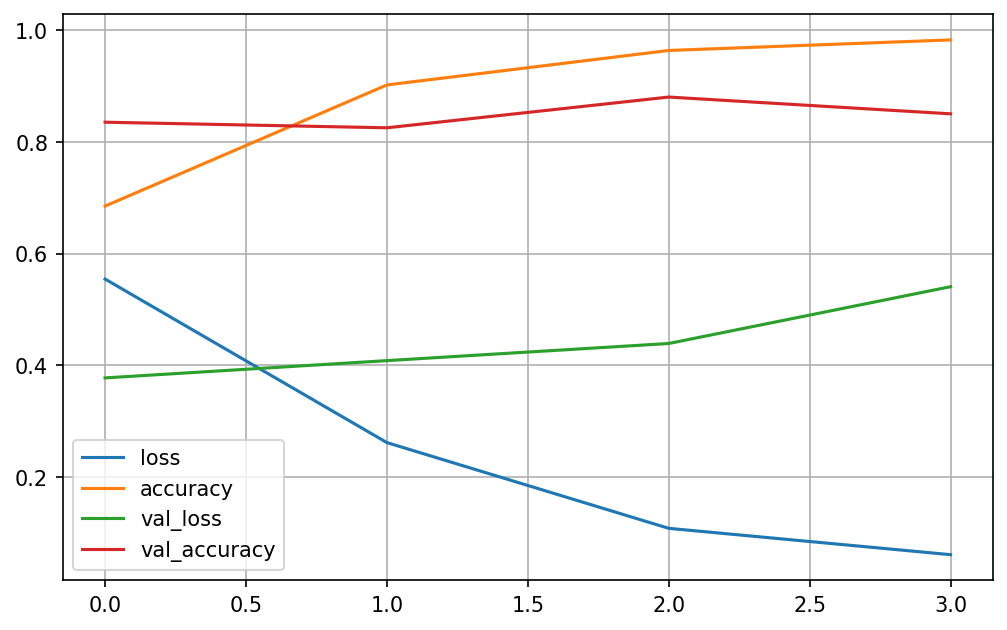

In [22]:
plot2(history)

## Model Evaluation

In [23]:
bert_model.evaluate(ds_test_encoded,
                    batch_size=batch_size)

25/25 [==============================] - 8s 329ms/step - loss: 0.5408 - accuracy: 0.8500


[0.5407702922821045, 0.8500000238418579]

In [24]:
y_test_pred = bert_model.predict(ds_test_encoded,
                                 batch_size=batch_size)

In [25]:
y_test_pred_class = y_test_pred[0].argmax(axis=1)

In [26]:
print(y_test_pred_class[:10])
print(y_test[:10])

[0 1 0 1 0 1 0 1 0 0]
[0 1 0 1 0 1 0 0 0 0]


In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j,
                     i,
                     "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j,
                     i,
                     "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.show()

In [28]:
cm = sklearn.metrics.confusion_matrix(y_test,
                                      y_test_pred_class,
                                      normalize=None)

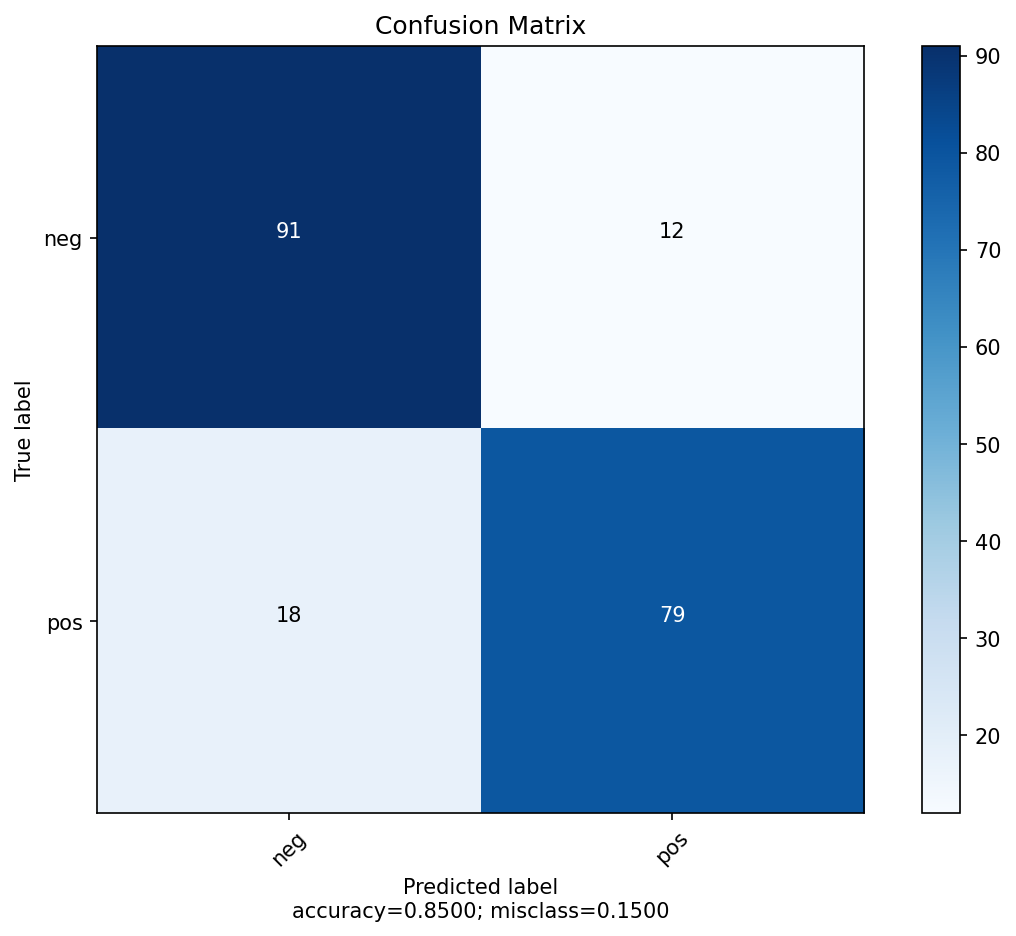

In [29]:
plot_confusion_matrix(cm,
                      normalize=False,
                      target_names=['neg', 'pos'],
                      title="Confusion Matrix")

In [30]:
# bert_model.save_weights(model_save_path)

In [31]:
# ## Loading from hard-drive

# # model_save_path='./sentiment-analysis-using-bert-keras/models/bert_model.h5'

# trained_model = TFBertForSequenceClassification.from_pretrained(
#     'bert-base-uncased', num_labels=2)
# trained_model.compile(loss='sparse_categorical_crossentropy',
#                       optimizer="adam",
#                       metrics=["accuracy"])
# trained_model.load_weights(model_save_path)

# preds = trained_model.predict([val_inp, val_mask], batch_size=32)

:::{tip}
It is possible to customize the BERT model for classification tasks. For more detail, please see `TFBertModel` (e.g., we can decide whether to make the embeddings trainable or not).
:::

## References

- [BERT Text Classification Using Keras](https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d)
- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
- [Text Extraction with BERT](https://keras.io/examples/nlp/text_extraction_with_bert/#text-extraction-with-bert)
- [Google's open-sourced tensorflow implementation of BERT](https://github.com/google-research/bert):